In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<h3>Introduction</h3>
In the year 1985, with the merger of two companies, Huston Natural Gas (HNG) and InterNorth, Enron was born. It was regarded as one of the best energy and natural gas companies in the world. And for six consecutive years was named "America's Most Innovative Company" by Fortune Magazine. Kenneth Lee Lay was the chairman and CEO of the company. Later, Jeffery Skilling was appointed as the new CEO while Ken Lay maintained his position as the chairman.<br>

However, what looked like a dream company from the outside was actually crumbling under the weight of billions of dollars of debts and failed project from within. These debts and losses were skillfully, willfully and systematically swept under the rug through accounting and auditing frauds over a sustained period of time. Eventually, Enron filled for bankruptcy in the year 2001 wiping out $78 billion in stock market value. It has since been known as the biggest case of corporate fraud in U.S history ever. <br>

Post the federal investigation of Enron Scandal, confidential information regarding the case crept into public domain. This information contained 600,000 emails generated by 158 enron employess and came to be known as the Enron Corpus.<br> 

My objective for this project is to use Machine Learning techniques to identify Persons of Interest from the data available from the Enron Corpus. A Person of Interest (POI) in this case is referred as person who was involved in the case. 

In [1]:
# importing libraries
from __future__ import division
from jupyterthemes import jtplot
import pickle
from custom_functions import find_outlier, train_predict_evaluate, score_chart
import math
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pprint import pprint
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# setting up plot style according to jupyter notebook theme
jtplot.style(grid=False, fscale=1.2)

# loading data
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
# creating a dataframe from dict
df = pd.DataFrame.from_dict(data_dict).T
df.reset_index(inplace = True)
df.rename(columns = {'index' : 'name'}, inplace = True)

# writing dataframe to .csv
df.to_csv('enron_data.csv')

# reading .csv into a dataframe
enron_df = pd.read_csv('enron_data.csv')
enron_df.drop('Unnamed: 0', axis = 1, inplace = True)

# checking data info
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
name                         146 non-null object
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt

In [3]:
# checking sample data
enron_df.head(6)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,NaN,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
1,BADUM JAMES P,NaN,178980.0,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466.0,257817.0
2,BANNANTINE JAMES M,NaN,NaN,-5104.0,NaN,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,...,NaN,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
3,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
4,BAY FRANKLIN R,400000.0,260455.0,-201641.0,NaN,frank.bay@enron.com,NaN,129142.0,NaN,NaN,...,NaN,69.0,False,145796.0,-82782.0,239671.0,NaN,NaN,827696.0,63014.0
5,BAZELIDES PHILIP J,NaN,684694.0,NaN,NaN,NaN,1599641.0,NaN,NaN,NaN,...,93750.0,874.0,False,NaN,NaN,80818.0,NaN,NaN,860136.0,1599641.0


<h3>Enron Data</h3>
The goal of this project, as I mentioned above, is to create model(s) that can effectively predict Person Of Interest (POI) and Non-Person Of Interest (non-POI) from the available dataset. Therefore, to begin there were a few things about the dataset that I wanted to know straight off the bat, like: 
<ul>
<li>Names of all the executives in the dataset</li>
<li>Number of total executives</li>
<li>Total number of features</li>
<li>Total number of POI's</li>
<li>Total number of non-POI's</li>
</ul>

In the cells below we can see data related to the queries I had. Later, I summarised these observations for more clarity:

In [4]:
# checking names
print('Names of all enron executive in the dataset: \n{}'.format([name for name in enron_df['name']]))

Names of all enron executive in the dataset: 
['ALLEN PHILLIP K', 'BADUM JAMES P', 'BANNANTINE JAMES M', 'BAXTER JOHN C', 'BAY FRANKLIN R', 'BAZELIDES PHILIP J', 'BECK SALLY W', 'BELDEN TIMOTHY N', 'BELFER ROBERT', 'BERBERIAN DAVID', 'BERGSIEKER RICHARD P', 'BHATNAGAR SANJAY', 'BIBI PHILIPPE A', 'BLACHMAN JEREMY M', 'BLAKE JR. NORMAN P', 'BOWEN JR RAYMOND M', 'BROWN MICHAEL', 'BUCHANAN HAROLD G', 'BUTTS ROBERT H', 'BUY RICHARD B', 'CALGER CHRISTOPHER F', 'CARTER REBECCA C', 'CAUSEY RICHARD A', 'CHAN RONNIE', 'CHRISTODOULOU DIOMEDES', 'CLINE KENNETH W', 'COLWELL WESLEY', 'CORDES WILLIAM R', 'COX DAVID', 'CUMBERLAND MICHAEL S', 'DEFFNER JOSEPH M', 'DELAINEY DAVID W', 'DERRICK JR. JAMES V', 'DETMERING TIMOTHY J', 'DIETRICH JANET R', 'DIMICHELE RICHARD G', 'DODSON KEITH', 'DONAHUE JR JEFFREY M', 'DUNCAN JOHN H', 'DURAN WILLIAM D', 'ECHOLS JOHN B', 'ELLIOTT STEVEN', 'FALLON JAMES B', 'FASTOW ANDREW S', 'FITZGERALD JAY L', 'FOWLER PEGGY', 'FOY JOE', 'FREVERT MARK A', 'FUGH JOHN L', 'GAHN ROB

In [5]:
# total number of names
print('Total number of names in the dataset: {}'.format(len(enron_df['name'])))

Total number of names in the dataset: 146


In [6]:
# checking feature list
feature_set = list(enron_df.drop('name', axis = 1))
print 'Feature List:\n',feature_set
print
print 'Number of features:', len(feature_set)

Feature List:
['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'email_address', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'poi', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

Number of features: 21


In [7]:
# checking for POI names
poi_name = enron_df.loc[enron_df['poi'] == True]['name']
print('Names of POIs:\n{}'.format(poi_name))
print ''
print 'Number of Persons Of Interest:', len(poi_name )
print ''
print 'Number of Non Person of Interset:', len(enron_df['name']) - len(poi_name)

Names of POIs:
7          BELDEN TIMOTHY N
15       BOWEN JR RAYMOND M
20     CALGER CHRISTOPHER F
22         CAUSEY RICHARD A
26           COLWELL WESLEY
31         DELAINEY DAVID W
43          FASTOW ANDREW S
54          GLISAN JR BEN F
59           HANNON KEVIN P
65             HIRKO JOSEPH
76            KOENIG MARK E
77         KOPPER MICHAEL J
79            LAY KENNETH L
112          RICE KENNETH D
113          RIEKER PAULA H
119              SHELBY REX
122      SKILLING JEFFREY K
144          YEAGER F SCOTT
Name: name, dtype: object

Number of Persons Of Interest: 18

Number of Non Person of Interset: 128


Here is a summary of the data from the cells above:
<ul>
<li>Total number of data points: 146</li>
<li>Total number of poi: 18</li>
<li>Total number of non-poi: 128</li>
<li>Total number of features: 21</li>
</ul>


<h3>Missing Values</h3>
Every feature (except poi) in the dataset has missing values or 'NaN' Values. I thought it would be useful to visualize the number of 'NaN' values for all the features. Below is a bar chart displaying those values. <br>



In [8]:
# Task 1: Select what features you'll use.

financial_features = ['salary', 'deferral_payments', 'total_payments',
                     'exercised_stock_options', 'bonus', 'restricted_stock',
                     'restricted_stock_deferred', 'total_stock_value', 'expenses', 
                     'loan_advances', 'director_fees', 'deferred_income', 'long_term_incentive']

email_features = ['to_messages', 'shared_receipt_with_poi', 'from_messages', 'other', 
                 'from_this_person_to_poi', 'email_address', 'from_poi_to_this_person']

poi = ['poi']

total_features = poi + financial_features + email_features

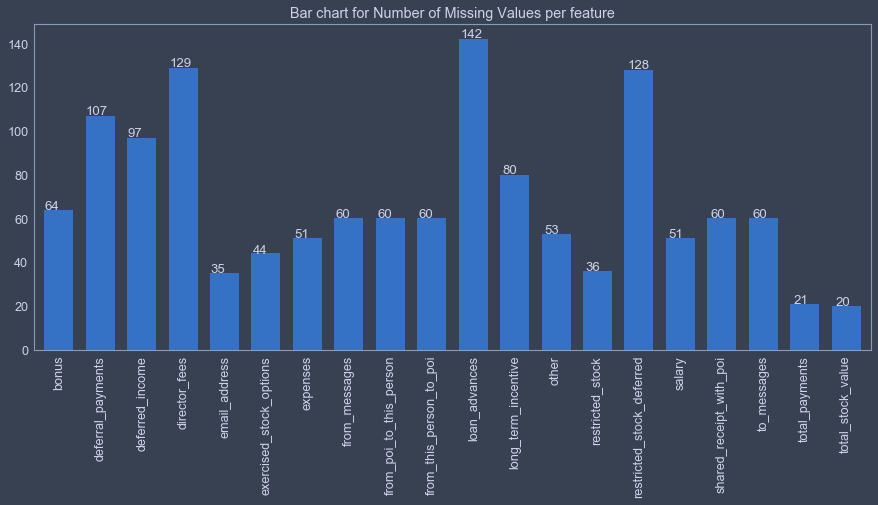

In [9]:
# plotting number of missing values in the dataset
bar = enron_df.isnull().sum().drop(['name', 'poi']).plot(kind= 'bar', 
                                                         figsize = (15, 6), 
                                                         width = 0.7)
plt.title('Bar chart for Number of Missing Values per feature')
for p in bar.patches:
    bar.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

I also wanted to know how many values were missing for every employee in the dataset. However, instead of plotting names of all the employees and their missing values, I chose to plot a bar chart for top 20 employees only. 

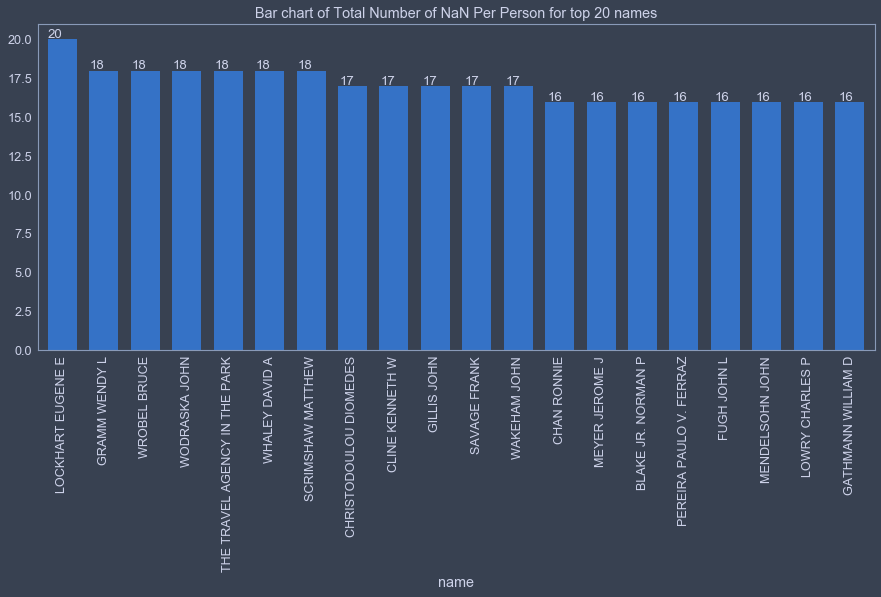

In [10]:
# plotting the top 20 names with most missing values
bar = pd.Series.sort_values(enron_df.drop('poi', axis = 1).groupby('name').sum().T.isnull().sum() + 1, 
                      ascending = False).head(20).plot(kind = 'bar', width = 0.7,
                                                      figsize = (15, 6))
plt.title('Bar chart of Total Number of NaN Per Person for top 20 names')
for p in bar.patches:
    bar.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

I further examined NaN values in email and financial features of the dataset separetly. For this, I used the lists <code>email_features</code> and <code>financial_features</code> I created earlier. I thought this will help me to detect outliers that might exist within these features. Below is a Bar chart displaying number of NaN values in financial features for top 20 executives.

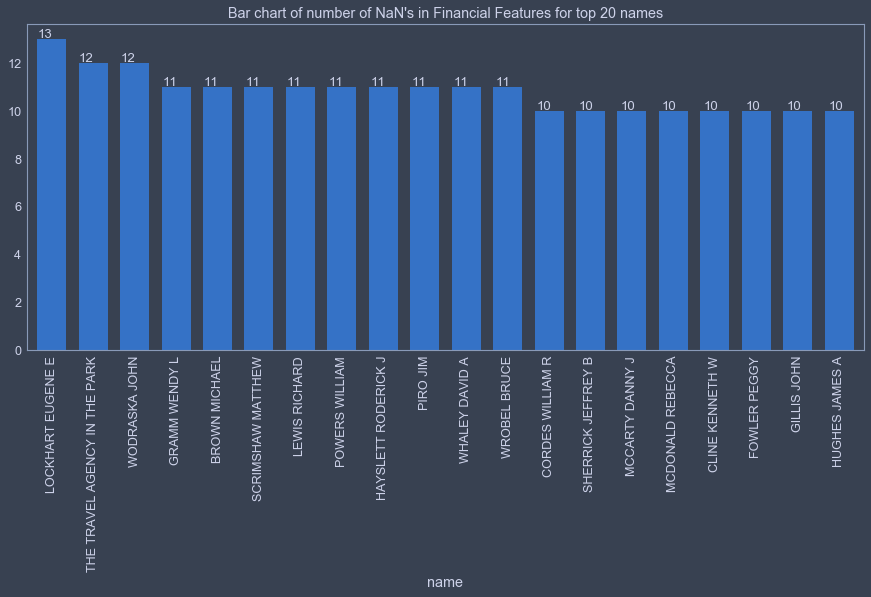

In [11]:
# plotting bar chart for missing values in financial features
bar = pd.Series.sort_values(enron_df[['name'] + financial_features].groupby('name').sum().T.isnull().sum(), 
            ascending = False).head(20).plot(kind = 'bar', 
                                             width = 0.7,
                                             figsize = (15, 6))
plt.title("Bar chart of number of NaN's in Financial Features for top 20 names")
for p in bar.patches:
    bar.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

Below is a Bar chart displaying number NaN values in email features for all the employees.

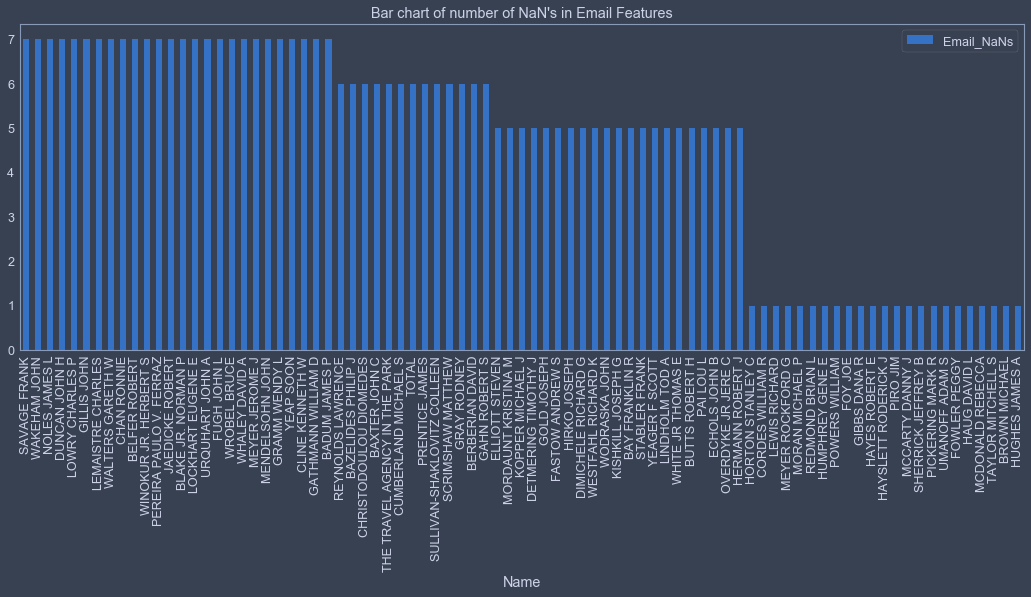

In [12]:
# creating a dict for collecting names and number of missing email features
email_nans_per_person = {}

for name in data_dict:
    for features in email_features:
        if data_dict[name][features] == 'NaN':
            email_nans_per_person[name] = email_nans_per_person.get(name, 0) + 1

# sorting dict keys and creating a data frame of names and number of nans
email_nan = pd.DataFrame(sorted(email_nans_per_person.items(), key = lambda x:x[1], reverse = True))
email_nan.columns = ['Name', 'Email_NaNs']

# plotting missing values in email features
bar3 = email_nan.plot(kind = 'Bar', x = 'Name', 
                               figsize = (18, 6))
plt.title("Bar chart of number of NaN's in Email Features")
plt.show()

<h3>Exploring Financial Features</h3>
I wanted to further explore the dataset, especially, its financial features. I was curious about knowing more on features like <code>salary</code>, <code>bonus</code>, <code>exercised_stock_options</code> and <code>long_term_incentives</code>. I printed summaries of these features using the describe() method. This gave me a good idea of how values within these features were disperesed.

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print('Salary Summary: \n{}'.format(enron_df['salary'].describe()))
print ''
print('Bonus Summary: \n{}'.format(enron_df['bonus'].describe()))
print ''
print('Exercised Stock Summary: \n{}'.format(enron_df['exercised_stock_options'].describe()))
print ''
print('Long term incentives Summary: \n{}'.format(enron_df['long_term_incentive'].describe()))

Salary Summary: 
count         95.000
mean      562194.295
std      2716369.155
min          477.000
25%       211816.000
50%       259996.000
75%       312117.000
max     26704229.000
Name: salary, dtype: float64

Bonus Summary: 
count         82.000
mean     2374234.610
std     10713327.969
min        70000.000
25%       431250.000
50%       769375.000
75%      1200000.000
max     97343619.000
Name: bonus, dtype: float64

Exercised Stock Summary: 
count         102.000
mean      5987053.775
std      31062006.569
min          3285.000
25%        527886.250
50%       1310813.500
75%       2547724.000
max     311764000.000
Name: exercised_stock_options, dtype: float64

Long term incentives Summary: 
count         66.000
mean     1470361.455
std      5942759.315
min        69223.000
25%       281250.000
50%       442035.000
75%       938672.000
max     48521928.000
Name: long_term_incentive, dtype: float64


Looking at the summaries I realised there were extreme values or outliers lying outside the interquartile range of the data of these features. I created a function called <code>find_outlier</code> to inspect these oultliers. This function was imported into the project from the <code><a href = 'custom_functions.py'>custom_functions.py</a></code> file.

Upon my inspection, I found one particular record which seemed out place, 'TOTAL'. 'TOTAL', obviously was the sum total of all the financial features for all the employess. However, it was being treated as one of the entires in the dataset and was skewing the figures quite acutely.

All 'TOTAL' values are printed below for reference:

In [14]:
# slicing and printing 'TOTAL' values
print(find_outlier(enron_df, 'bonus').loc[[130]].T)

                                    130
name                              TOTAL
bonus                      97343619.000
deferral_payments          32083396.000
deferred_income           -27992891.000
director_fees               1398517.000
email_address                       NaN
exercised_stock_options   311764000.000
expenses                    5235198.000
from_messages                       NaN
from_poi_to_this_person             NaN
from_this_person_to_poi             NaN
loan_advances              83925000.000
long_term_incentive        48521928.000
other                      42667589.000
poi                               False
restricted_stock          130322299.000
restricted_stock_deferred  -7576788.000
salary                     26704229.000
shared_receipt_with_poi             NaN
to_messages                         NaN
total_payments            309886585.000
total_stock_value         434509511.000


<h3>Outlier Removal</h3>
Plots from the Missing Values section and a brief exploration of financial feaures revealed atleast three Outliers quite distinctly. The first one as I mentioned above is: "TOTAL". I removed it to avoid its impact on the prediction models. The second is:  "LOCKHART EUGENE E". This person had only NaN values in his entire feature set. I removed this record because it did not provide any significant input for our predictive models. The third is: "THE TRAVEL AGENCY IN THE PARK". As the goal of the models is to predict Person Of Interest, this data point did not seem to meet that criterion as it is not a name of a person. I decided to remove it as well.

In [15]:
print 'Outlier Names:'
enron_df[(enron_df['name'] == 'TOTAL') | (enron_df['name'] == 'THE TRAVEL AGENCY IN THE PARK') 
        | (enron_df['name'] == 'LOCKHART EUGENE E')]

Outlier Names:


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
84,LOCKHART EUGENE E,nan,nan,nan,nan,NaN,nan,nan,nan,nan,...,nan,nan,False,nan,nan,nan,nan,nan,nan,nan
127,THE TRAVEL AGENCY IN THE PARK,nan,nan,nan,nan,NaN,nan,nan,nan,nan,...,nan,362096.000,False,nan,nan,nan,nan,nan,362096.000,nan
130,TOTAL,97343619.000,32083396.000,-27992891.000,1398517.000,NaN,311764000.000,5235198.000,nan,nan,...,48521928.000,42667589.000,False,130322299.000,-7576788.000,26704229.000,nan,nan,309886585.000,434509511.000


In [16]:
# Task 2: Remove outliers from data_dict
data_dict.pop('TOTAL', 0)
data_dict.pop('LOCKHART EUGENE E', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
print('Three outliers removed: {}, {}, {}'.format('TOTAL', 'LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK'))

# removing outliers from dataframe
enron_df.drop(enron_df.index[[84, 127, 130]], inplace = True)

Three outliers removed: TOTAL, LOCKHART EUGENE E, THE TRAVEL AGENCY IN THE PARK


<h3>Exploration post outlier removal</h3>
I continued exploring financial features to familiarize myself with the dataset even more. I had many questions regarding the distribution of financial records, regarding which executives got higher salaries, bonuses or stock options and regarding how the features were correlated. I decided to plot a series of graphs in order to seek answers to such questions. The first in this series of graphs were histograms of various features I thought were important to analyse. Next, I plotted a series of scatter plots to observe correspondence between features. 

Below are a series of histograms displaying distribution of various features of interest. The most obvious thing to notice in these distributions is how all of them are skewed to the right. 

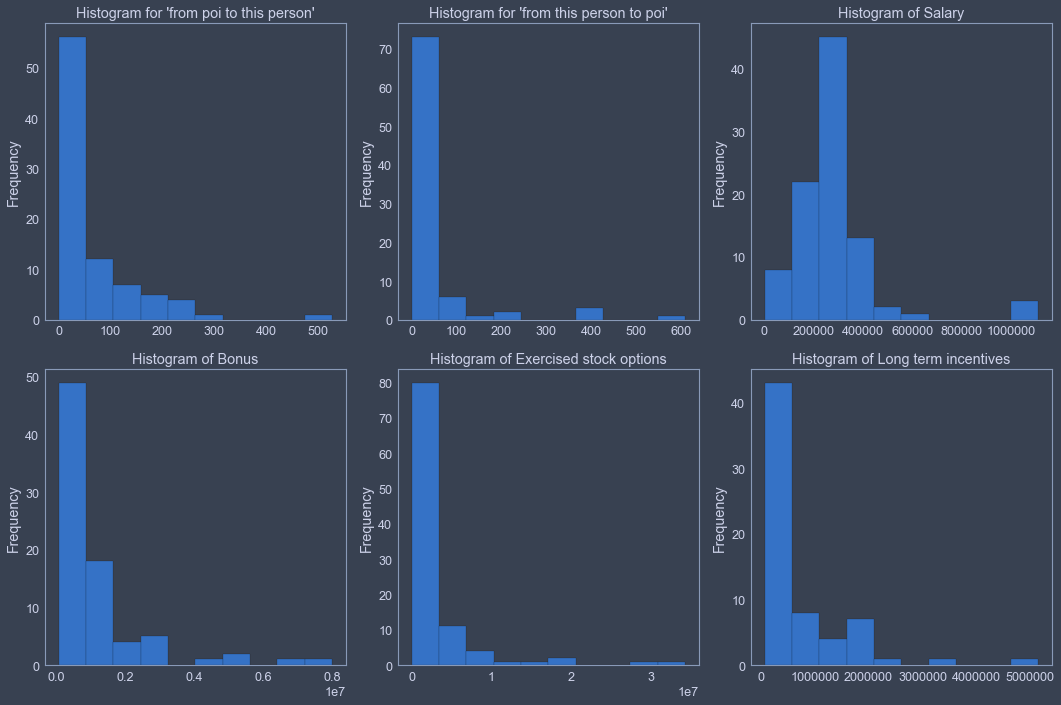

In [17]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
#fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
enron_df['from_poi_to_this_person'].plot(kind = 'hist', x = 'from_poi_to_this_person', 
                                         edgecolor = 'black', ax=ax1)
ax1.set_title("Histogram for 'from poi to this person'")

enron_df['from_this_person_to_poi'].plot(kind = 'hist', x = 'from_this_person_to_poi',
                                         edgecolor = 'black', ax=ax2)
ax2.set_title("Histogram for 'from this person to poi'")

enron_df['salary'].plot(kind = 'hist', x = 'salary', edgecolor = 'black', ax=ax3)
ax3.set_title('Histogram of Salary')

enron_df['bonus'].plot(kind = 'hist', x = 'bonus', edgecolor = 'black', ax=ax4)
ax4.set_title('Histogram of Bonus')

enron_df['exercised_stock_options'].plot(kind = 'hist', x = 'exercised_stock_options',
                                         edgecolor = 'black', ax=ax5)
ax5.set_title('Histogram of Exercised stock options')

enron_df['long_term_incentive'].plot(kind = 'hist', x = 'long_term_incentive',
                                     edgecolor = 'black', ax=ax6)
ax6.set_title('Histogram of Long term incentives')

plt.tight_layout()
plt.show()

Below are a series of scatter plots to examine correlations between <code>from_poi_to_this_person</code> vs <code>from_this_person_to_poi</code>, <code>salary</code> vs <code>bonus</code>, <code>salary</code> vs <code>long_term_incentives</code> and <code>salary</code> vs <code>exercised_stock_options</code>. These are all meaningfully positive correlations. <code>from_poi_to_this_person</code>, <code>from_this_person_to_poi</code>, <code>salary</code>, <code>bonus</code>, <code>long_term_incentives</code>, <code>exercised_stock_options</code> I thought were important features because they could be helpful in identifying POIs.

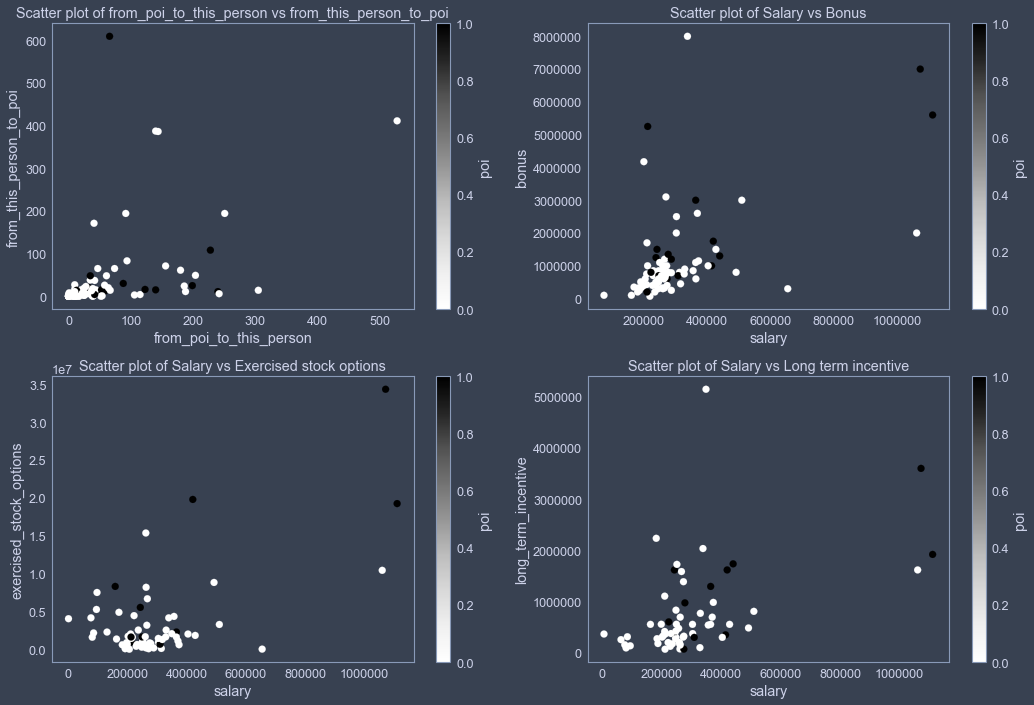

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
#fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
enron_df.plot(kind = 'scatter', x = 'from_poi_to_this_person',
              y = 'from_this_person_to_poi', ax=ax1, c = 'poi',
             s = 50)
ax1.set_title("Scatter plot of from_poi_to_this_person vs from_this_person_to_poi")

enron_df.plot(kind = 'scatter', x = 'salary', y = 'bonus', ax=ax2, c = 'poi',
             s = 50)
ax2.set_title("Scatter plot of Salary vs Bonus")

enron_df.plot(kind = 'scatter', x = 'salary', y = 'exercised_stock_options', ax=ax3, c = 'poi',
             s = 50)
ax3.set_title('Scatter plot of Salary vs Exercised stock options')

enron_df.plot(kind = 'scatter', x = 'salary', y = 'long_term_incentive', ax=ax4, c = 'poi',
             s = 50)
ax4.set_title('Scatter plot of Salary vs Long term incentive')

plt.tight_layout()
plt.show()

<h3>Feature Engineering</h3>
I created 5 new features from the available dataset, their names are:
<ul>
<li><code>'from_ratio'</code></li> 
<li><code>'to_ratio'</code></li> 
<li><code>'exercised_stock_to_salary_ratio'</code></li>
<li><code>'bonus_to_salary_ratio'</code></li> 

<li><code>'incentives_to_salary_ratio'</code></li> 
</ul>

<code>'from_ratio'</code> and <code>'to_ratio</code> depict ratios of a person receiving and sending emails from POI and to POI respectively. Because POIs are more likely to contact each other than non-POIs, I thought these two features could help the performace of the models for a better prediction. 

The other three features are based on the financial features of the dataset. Infact, the new features are strictly derived by keeping <code>'salary'</code> as one of the constant features in computing the ratios. I thought, salary could be used as a feature to distinguish POIs and non-POIs as POIs might be getting higher incomes than non-POIs. And as salary has a strong positive correlation with <code>'bonus'</code>, <code>'exercised_stock_options'</code> and <code>'long_term_incentive'</code> it can be strongly assumed that POIs might be getting higher bonuses, incentives and stock option than non-POIs as well. Therefore, if I could use their ratios it might improve the models performace based on the composition of those ratios.   

In [19]:
# Task 3: Create new feature(s)
# Store to my_dataset for easy export below.
my_dataset = data_dict

def ratio(feature1, feature2):
    '''Returns a ratio of two features, which are strings, if they aren't 
    equal to NaN. Otherwise returns a 0.
    '''
    
    if feature1 != 'NaN'and feature2 != 'NaN':
        return feature1/feature2
    
    return 0

def new_feature(feature1, feature2, new_feature):
    '''This function updates a dictionary named my_dataset with a new feature. 
    Takes in three strings.
    '''
    for name in my_dataset:
        my_dataset[name][new_feature] = ratio(my_dataset[name][feature1], 
                                              my_dataset[name][feature2])
    
# creating new features called from_ratio
new_feature('from_poi_to_this_person', 'to_messages', 'from_ratio')

# creating a new feature called to_ratio
new_feature('from_this_person_to_poi', 'from_messages', 'to_ratio')

# creating new features called 'exercised_stock_to_salary_ratio'
new_feature('exercised_stock_options', 'salary', 'exercised_stock_to_salary_ratio')

# creating a new feature called bonus_to_salary_ratio
new_feature('bonus', 'salary', 'bonus_to_salary_ratio')

# creating a new feature called incentives_to_salary_ratio
new_feature('long_term_incentive', 'salary', 'incentives_to_salary_ratio')

In [20]:
print'Dataset with new features:\n', my_dataset.values()[0].keys()

Dataset with new features:
['to_messages', 'to_ratio', 'deferral_payments', 'bonus_to_salary_ratio', 'expenses', 'poi', 'deferred_income', 'email_address', 'long_term_incentive', 'incentives_to_salary_ratio', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'director_fees', 'bonus', 'total_stock_value', 'from_poi_to_this_person', 'from_this_person_to_poi', 'restricted_stock', 'salary', 'total_payments', 'from_ratio', 'exercised_stock_options', 'exercised_stock_to_salary_ratio']


<h3>Feature Selection and Scaling</h3>
To intelligently select features I used SelectKBest function to get the score of each features. I then sorted those scores and selected the 10 best features out of all the available features. I removed two features <code>'to_ratio</code> and <code>'bonus_to_salary_ratio'</code> that I had created from this feature list. I did so to retain only the original features of the dataset as these were the final features I wanted to use to build my models. Here is the list of all the selected features and their scores (including <code>'to_ratio</code> and <code>'bonus_to_salary_ratio'</code>):

In [21]:
 # adding new features to the list of features
new_features_list = total_features + ['from_ratio', 'to_ratio', 'exercised_stock_to_salary_ratio',
                                      'bonus_to_salary_ratio', 'incentives_to_salary_ratio']

# removing email_address
new_features_list.remove('email_address')

# extracting features and labels from dataset
data = featureFormat(my_dataset, new_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# selecting the top 10 features
selector = SelectKBest(f_classif, k = 10)
selector.fit_transform(features, labels)
scores = zip(new_features_list[1:], selector.scores_)
sorted_scores = sorted(scores, key = lambda x:x[1], reverse = True)
best_features_list = [new_features_list[0]] + list(map(lambda x: x[0], sorted_scores))[0:9]
print('Best selected features:\n{}'.format(sorted_scores[:9]))

# removing new features to retain only the original features
best_features_list.remove('to_ratio')
best_features_list.remove('bonus_to_salary_ratio')

# Extracting and scaling best features
new_data = featureFormat(my_dataset, best_features_list, sort_keys = True)
labels, features = targetFeatureSplit(new_data)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Extracting and scaling new features
updated_data = featureFormat(my_dataset, best_features_list + new_features_list[-5:], 
                             sort_keys = True)
new_labels, new_features = targetFeatureSplit(updated_data)
new_scaled_features = scaler.fit_transform(new_features)

Best selected features:
[('exercised_stock_options', 24.815079733218194), ('total_stock_value', 24.182898678566879), ('bonus', 20.792252047181535), ('salary', 18.289684043404513), ('to_ratio', 16.409712548035792), ('deferred_income', 11.458476579280369), ('bonus_to_salary_ratio', 10.783584708160824), ('long_term_incentive', 9.9221860131898225), ('restricted_stock', 9.2128106219771002)]


Since there is a lot of variation in the data, I used MinMax scaler to normalize the data and bring the chosen features to a common scale.

Furthermore, to test how the model will perform if new features are added to it, I created another feature list. This time I added all the newly created features to the list of features I had obtained from the SelectKBest function. I used the MinMax scaler to normalize and rescale these features as well. 

<h3>Model Validation, Selection and Scores</h3>

In Model validation a trained model is evaluated using a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test how well the model will perform when new data points are introduced.

However, while splitting a data set into training and test sets there is a tradeoff where data points are lost from the training set and assigned to the test set. This where cross-validation technique known as k-fold cross-validation comes into picture. By using k-fold cross-validation, the original data set is randomly partitioned into k subsamples and one is left out in each iteration. The performance of the test set is computed by taking an average of the total number of iterations. 

If cross validation is not performed on a data set, if a data set is not processed into a training and test sets, a machine learning algorithm could become a victim of over fitting. Because the algorithm will be built by fitting the entire data set, it won't learn anything new about the data and won't be able to adapt itself to new information. As a result, the algorithm will perform counter productively whenever it gets exposed to new data points.    

Below is a list of five algorithms I tried with an objective to classify which employees are more likely to be Persons Of Interest: 
<ul>
<li>Gaussian Naive Bayes</li> 
<li>Support Vector Classifier</li>
<li>Decision Tree Classifier</li> 
<li>Random Forest Classifier</li>
<li>Logistic Regression</li>
</ul> 

I used the <code>train_test_split</code> function to split the data into a 70:30 ratio; 70% for training, 30% for testing. Furthermore, I used average scores of three metrics accuarcy, precision and recall to evaluate the performance of my models. This average was computed based on 20 iterations of each algorithm. Below is quick demo of each of the five algorithms tested with and without new features. These algorithms are used straight out of the box without tuning any parameters. I used two function <code>train_predict_evaluate</code> and <code>score_chart</code> to evaluate the scores of each algorithm and plot a comparison. 

Scores from this preliminary test showed that for all the algorithms the accuracy scores had marginally dropped after introduction of new features. On the other hand, there was a decent improvement in the recall and precision scores of Decision Tree Classifier, Random Forrest and Logistic Regression models after new features were introduced. 

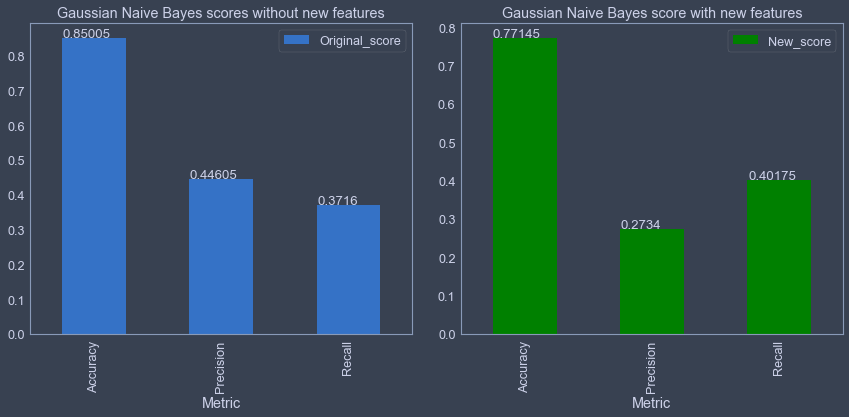

In [23]:
# predicting and plotting GaussianNB
predict = train_predict_evaluate(GaussianNB(), scaled_features, labels, new_scaled_features, new_labels)
score_chart(predict, 'Gaussian Naive Bayes')

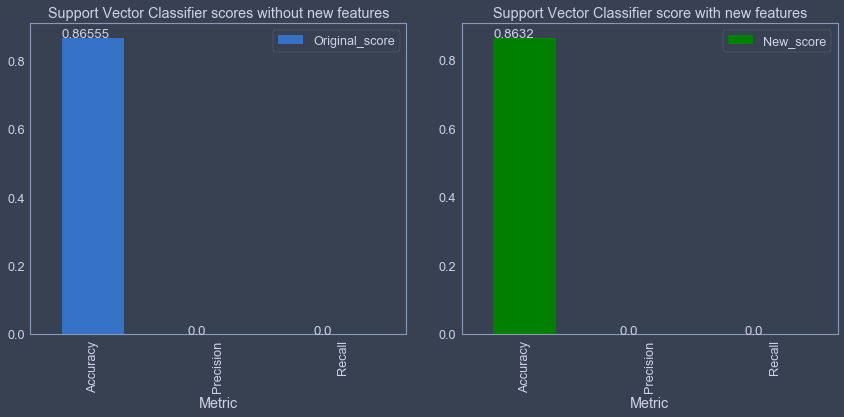

In [24]:
# predicting and plotting SVC
predict = train_predict_evaluate(SVC(), scaled_features, labels, new_scaled_features, new_labels)
score_chart(predict, 'Support Vector Classifier')

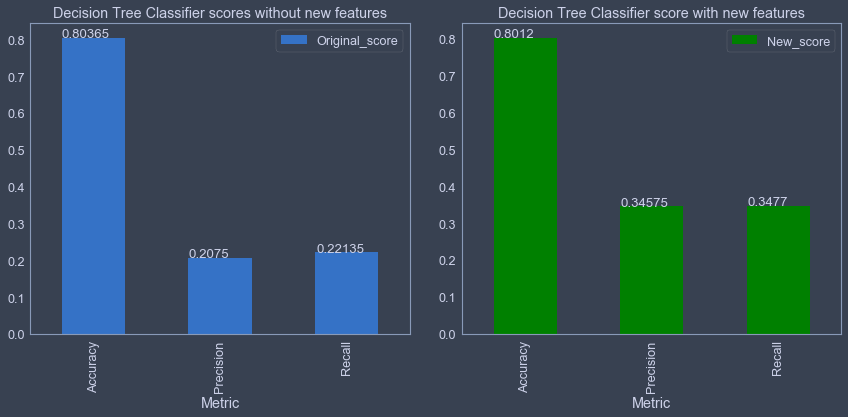

In [25]:
# predicting and plotting DecisionTreeClassifier
predict = train_predict_evaluate(DecisionTreeClassifier(), scaled_features, labels, new_scaled_features, new_labels)
score_chart(predict, 'Decision Tree Classifier')

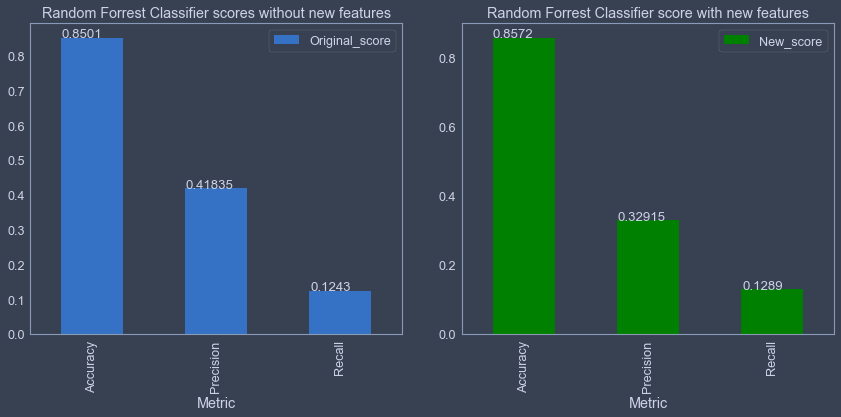

In [26]:
# predicting and plotting RandomForrestClassifier
predict = train_predict_evaluate(RandomForestClassifier(), scaled_features, labels, new_scaled_features, new_labels)
score_chart(predict, 'Random Forrest Classifier')

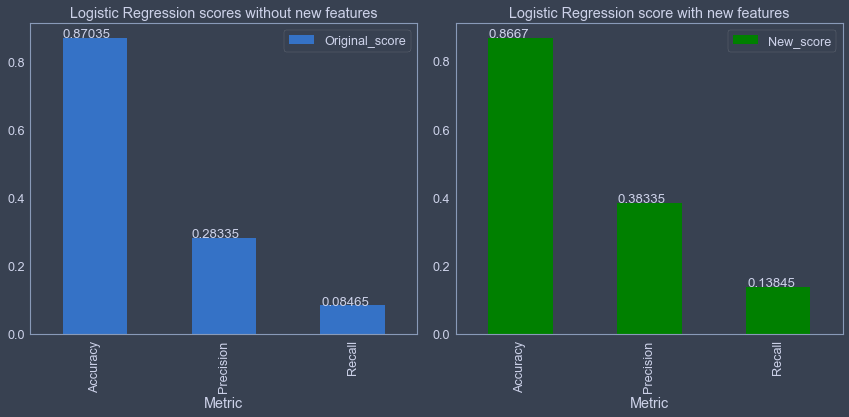

In [27]:
# predicting and plotting LogisticRegression
predict = train_predict_evaluate(LogisticRegression(), scaled_features, labels, new_scaled_features, new_labels)
score_chart(predict, 'Logistic Regression')

<h3>Model Tuning and Final Testing</h3>
Tuning parameters of a model is a process in which the parameters of a model are tweaked in several ways in order to achieve optimal predictions. In this case, I used GridSearchCV from sklearn for tuning the parameters of my algorithms. Using Grid search I was able to get the best available parameters for each of the algorithms I used (except GaussianNB, because it doesn't require parameters).

Here is brief report on the parameter which were tuned for each algorithm:

<b>Decision Tree Classifier:</b><br> 
criterion = 'gini' or 'entropy'<br>
splitter = 'best' or 'random'<br>
min_samples_leaf = 1,2,3,4,5<br>
min_samples_split = 2,3,4,5<br>

<b>Random Forrest Classifier:</b><br>
min_samples_leaf = 1,2,3,4,5<br>
min_samples_split = 2,3,4,5<br>
n_estimators = 5,10,20,30<br>

<b>Support Vector Classifier:</b><br>
kernel = 'linear', 'rbf' or 'sigmoid'<br>
gamma = 1, 0.1, 0.01, 0.001, 0.0001<br>
C = 0.1, 1, 10, 100, 1000<br>

<b>Logistic Regression:</b><br>
C = 0.05, 0.5, 1, 10, 100, 1000, 10^5, 10^10<br>
tol = 0.1, 10^-5, 10^-10<br>

I used a combination of two functions <code>parameter_tuning</code> and <code>model_evaluation</code> to print out average accuracy, precision and recall scores along with the best hyperparameters for a model after tuning it for 100 iterations. 

Below are the results of the final test:

In [28]:
def parameter_tuning(grid_search, features, labels, params, iters = 100):
    """ This function tunes the algorithm using grid search and prints out the 
    average evaluation metric results after performing the tuning for iter times,
    and the best hyperparameters for the model.
    """
    accuracy = []
    precision = []
    recall = []
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.3, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)

        accuracy.append(round(accuracy_score(labels_test, predicts),3))
        precision.append(round(precision_score(labels_test, predicts),3))
        recall.append(round(recall_score(labels_test, predicts),3))
    print "accuracy: {}".format(np.mean(accuracy))
    print "precision: {}".format(np.mean(precision))
    print "recall: {}".format(np.mean(recall))
    
    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print 'Best Features:'
        print("%s = %r, " % (param_name, best_params[param_name]))

In [29]:
def model_evaluation(classifier, parameters, algo_name):
    '''This function conducts a grid search and calls the function 
    parameter_tuning to print metric scores and best parameters.'''
    
    clf = classifier
    param = parameters
    grid_search = GridSearchCV(estimator = clf, param_grid = param)
    print(algo_name + " evaluation:")
    parameter_tuning(grid_search, scaled_features, labels, param)
    #print ''
    #parameter_tuning(nb_grid_search, new_scaled_features, new_labels, nb_param)

In [31]:
model_evaluation(GaussianNB(), {}, 'Gaussian Naive Bayes')

Gaussian Naive Bayes evaluation:
accuracy: 0.8548
precision: 0.43296
recall: 0.37321


In [32]:
dtc_param = {'criterion':('gini', 'entropy'),
                  'splitter':('best','random'),
                  'min_samples_leaf':[1,2,3,4,5], 
                  'min_samples_split':[2,3,4,5]}

model_evaluation(DecisionTreeClassifier(), dtc_param, 'Decision Tree Classifier')

Decision Tree Classifier evaluation:
accuracy: 0.83795
precision: 0.22418
recall: 0.13335
min_samples_split = 4, 
splitter = 'random', 
criterion = 'gini', 
min_samples_leaf = 3, 


In [33]:
svm_param = {'kernel':('linear', 'rbf', 'sigmoid'),
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'C': [0.1, 1, 10, 100, 1000]}

model_evaluation(SVC(), svm_param, 'Support vector Classifier')

Support vector Classifier evaluation:
accuracy: 0.86099
precision: 0.13628
recall: 0.05099
kernel = 'linear', 
C = 1, 
gamma = 1, 


In [34]:
rf_param = {'min_samples_leaf':[1,2,3,4,5], 
            'min_samples_split':[2,3,4,5], 
            'n_estimators':[5,10,20,30]}

model_evaluation(RandomForestClassifier(), rf_param, 'Random Forrest Classifier')

Random Forrest Classifier evaluation:
accuracy: 0.86145
precision: 0.3669
recall: 0.1464
min_samples_split = 2, 
n_estimators = 10, 
min_samples_leaf = 1, 


In [35]:
logR_param =   {"C":[0.05, 0.5, 1, 10, 100, 1000, 10**5, 10**10],
                    "tol":[0.1, 10**-5, 10**-10]}
model_evaluation(LogisticRegression(), logR_param, 'Logistic Regression')

Logistic Regression evaluation:
accuracy: 0.86623
precision: 0.1898
recall: 0.07158
C = 10000000000, 
tol = 1e-10, 


An accuracy score of an algorithm measures the proportion of correct predictions made divided by the total number of predictions made. For example, the accuracy of our Naive Bayes model is 0.855. Meaning that out of the total number of examined cases the precentage of true results (both true positives and true negatives) is 85.5%. 

A precision score of an algorithm measures the proportion of true positives from all cases that are classified as positives. It is also called the Positive Predictive Value. For our Naive Bayes model, the precision score is 0.433. Meaning that out 100 executives classified as POIs, 43.3 are actually POIs. Precision can be thought of as a measure of a classifiers exactness. 

Recall score of an algorithm is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate. For our Naive Bayes model, a recall of 0.373 means that out of 100 true POIs existing in the dataset, 37 POIs are correctly classified as POIs. Recall can be thought of as a measure of a classifiers completeness.

As we can see here, in terms of accuracy score all the algorithms are almost at par with each other. Logistic Regression, however, gave the highest accuracy score of 0.866. Gaussian Naive Bayes classifier gave the best precision score of 0.433 and recall score of 0.373.

Therefore, Gaussian Naive Bayes, with an accuracy: 0.855, precision: 0.433 and recall: 0.373, is the best performing algorithm in this case. 



In [25]:
clf = GaussianNB()
features_list = best_features_list
test_classifier(clf, my_dataset, features_list)

#Dump your classifier, dataset, and features_list so 
#anyone can run/check your results.
dump_classifier_and_data(clf, my_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.84671	Precision: 0.45660	Recall: 0.38400	F1: 0.41716	F2: 0.39661
	Total predictions: 14000	True positives:  768	False positives:  914	False negatives: 1232	True negatives: 11086



<h3>Conclusion</h3>
The objective of this project was to classify Person Of Interest in Enron data using machine learning algorithms of my choice. During the course of this project, I performed basic exploratory data analysis, removed outlier, engineered new features and selected the best scoring features using SelectKBest function. During the modeling phase of the project, I applied five different algorithms on the orginal features list as well as new features list and evaluate my tests using accuracy, precision and recall metrics. Finally, after comparing the score, Gaussian Naive Bayes classifier was observed to be the best performing algorithm for classifying POIs. 